Iteration 0:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


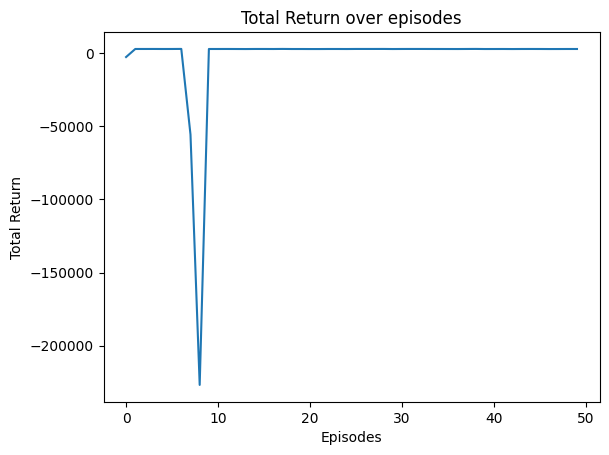

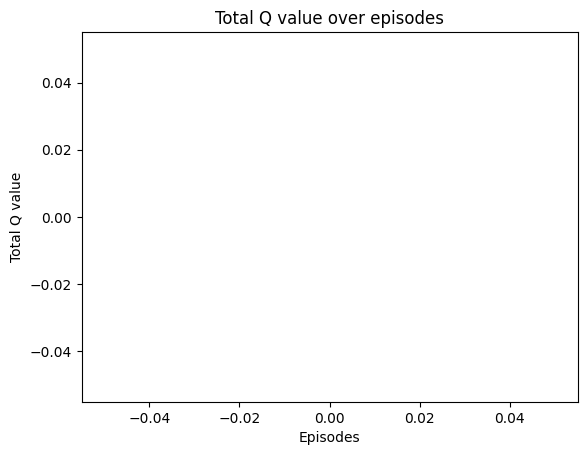

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from env.custom_environment import CustomEnvironment
from tqdm import tqdm

# Replay Buffer定义
class StepReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        return batch

    def __len__(self):
        return len(self.buffer)

# QMIX网络定义
class QMixNet(nn.Module):
    def __init__(self, args):
        super(QMixNet, self).__init__()
        self.args = args

        if args.two_hyper_layers:
            self.hyper_w1 = nn.Sequential(nn.Linear(args.state_shape * args.n_agents, args.hyper_hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(args.hyper_hidden_dim, args.n_agents * args.qmix_hidden_dim))
            self.hyper_w2 = nn.Sequential(nn.Linear(args.state_shape * args.n_agents, args.hyper_hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(args.hyper_hidden_dim, args.qmix_hidden_dim * 1))
        else:
            self.hyper_w1 = nn.Linear(args.state_shape * args.n_agents, args.n_agents * args.qmix_hidden_dim)
            self.hyper_w2 = nn.Linear(args.state_shape * args.n_agents, args.qmix_hidden_dim * 1)

        self.hyper_b1 = nn.Linear(args.state_shape * args.n_agents, args.qmix_hidden_dim)
        self.hyper_b2 = nn.Sequential(nn.Linear(args.state_shape * args.n_agents, args.qmix_hidden_dim),
                                      nn.ReLU(),
                                      nn.Linear(args.qmix_hidden_dim, 1))

    def forward(self, q_values, states):
        episode_num = q_values.size(0)
        q_values = q_values.view(episode_num, 1, self.args.n_agents)
        states = states.view(episode_num, -1)

        w1 = torch.abs(self.hyper_w1(states))
        b1 = self.hyper_b1(states)
        w1 = w1.view(episode_num, self.args.n_agents, self.args.qmix_hidden_dim)
        b1 = b1.view(episode_num, 1, self.args.qmix_hidden_dim)

        hidden = F.elu(torch.bmm(q_values, w1) + b1)
        w2 = torch.abs(self.hyper_w2(states))
        b2 = self.hyper_b2(states)
        w2 = w2.view(episode_num, self.args.qmix_hidden_dim, 1)
        b2 = b2.view(episode_num, 1, 1)

        q_total = torch.bmm(hidden, w2) + b2
        q_total = q_total.view(episode_num, -1, 1)
        return q_total

# RNN定义
class RNN(nn.Module):
    def __init__(self, input_shape, args):
        super(RNN, self).__init__()
        self.args = args
        self.fc1 = nn.Linear(input_shape, args.rnn_hidden_dim)
        self.rnn = nn.GRUCell(args.rnn_hidden_dim, args.rnn_hidden_dim)
        self.fc2 = nn.Linear(args.rnn_hidden_dim, args.n_actions)

    def forward(self, obs, hidden_state):
        x = F.relu(self.fc1(obs))
        h_in = hidden_state.reshape(-1, self.args.rnn_hidden_dim)
        h = self.rnn(x, h_in)
        q = self.fc2(h)
        return q, h

class QMIX:
    def __init__(self, env, args, use_cuda=False):
        self.env = env
        self.args = args
        self.use_cuda = use_cuda
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.replay_buffer = StepReplayBuffer(args.buffer_size)
        self.rnn = RNN(args.obs_shape, args).to(self.device)
        self.qmix_net = QMixNet(args).to(self.device)

        self.target_rnn = RNN(args.obs_shape, args).to(self.device)
        self.target_qmix_net = QMixNet(args).to(self.device)

        self.optimizer = Adam(list(self.rnn.parameters()) + list(self.qmix_net.parameters()), lr=args.lr)
        self.loss_fn = nn.MSELoss()

        self.update_target_network()
        self.total_steps = 0  # 增加一个计数器来记录总的训练步数

        self.epsilon = self.args.epsilon_start

    def update_target_network(self):
        self.target_rnn.load_state_dict(self.rnn.state_dict())
        self.target_qmix_net.load_state_dict(self.qmix_net.state_dict())

    def adjust_epsilon(self):
        decay_rate = (self.args.epsilon_start - self.args.epsilon_end) / (self.args.num_episodes / 2)
        self.epsilon = max(self.args.epsilon_end, self.epsilon - decay_rate)

    def choose_action(self, obs, hidden_state):
        actions = {}
        new_hidden_state = {}

        for agent in self.env.agents:
            agent_obs = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
            agent_hidden_state = torch.tensor(hidden_state[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
            q_values, new_agent_hidden_state = self.rnn(agent_obs, agent_hidden_state)

            if random.random() < 0.01:
                action = random.choice(range(self.args.n_actions))  # 以 epsilon 的概率随机选择动作
            else:
                action = q_values.argmax(dim=-1).item()  # 以 1-epsilon 的概率选择 Q 值最大的动作

            actions[agent] = action
            new_hidden_state[agent] = new_agent_hidden_state.detach().cpu().numpy()
        #print(self.epsilon)
        return actions, new_hidden_state

    def train(self):
        if len(self.replay_buffer) < self.args.minimal_size:
            self.adjust_epsilon()
            return

        batch = self.replay_buffer.sample(self.args.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = {agent: torch.tensor(np.array([s[agent] for s in states]), dtype=torch.float32).to(self.device) for agent in self.env.agents}
        actions = {agent: torch.tensor(np.array([a[agent] for a in actions]), dtype=torch.int64).to(self.device) for agent in self.env.agents}
        rewards = {agent: torch.tensor(np.array([r[agent] for r in rewards]), dtype=torch.float32).to(self.device) for agent in self.env.agents}
        next_states = {agent: torch.tensor(np.array([ns[agent] for ns in next_states]), dtype=torch.float32).to(self.device) for agent in self.env.agents}
        dones = {agent: torch.tensor(np.array([d[agent] for d in dones]), dtype=torch.float32).to(self.device) for agent in self.env.agents}

        hidden_state = {agent: torch.zeros((self.args.batch_size, self.args.rnn_hidden_dim), dtype=torch.float32).to(self.device) for agent in self.env.agents}
        next_hidden_state = {agent: torch.zeros((self.args.batch_size, self.args.rnn_hidden_dim), dtype=torch.float32).to(self.device) for agent in self.env.agents}

        q_values = {agent: self.rnn(states[agent], hidden_state[agent])[0].gather(1, actions[agent].unsqueeze(-1)).squeeze(-1) for agent in self.env.agents}
        next_q_values = {agent: self.target_rnn(next_states[agent], next_hidden_state[agent])[0].max(dim=-1)[0] for agent in self.env.agents}

        targets = {agent: rewards[agent] + self.args.gamma * next_q_values[agent] * (1 - dones[agent]) for agent in self.env.agents}

        q_values_tensor = torch.stack(list(q_values.values()), dim=1)
        targets_tensor = torch.stack(list(targets.values()), dim=1)
        states_tensor = torch.cat([states[agent].view(self.args.batch_size, -1) for agent in self.env.agents], dim=1)

        q_total = self.qmix_net(q_values_tensor, states_tensor)
        targets_total = self.target_qmix_net(targets_tensor, states_tensor)

        loss = self.loss_fn(q_total, targets_total.detach())
        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.rnn.parameters(), 0.5)
        torch.nn.utils.clip_grad_norm_(self.qmix_net.parameters(), 0.5)

        self.optimizer.step()

        '''if self.total_steps % 5 == 0:
            print(f"Step {self.total_steps}, Loss: {loss.item()}, Q_total: {q_total.mean().item()}")'''

        if self.total_steps % self.args.target_update_interval == 0:
            self.update_target_network()
        self.total_steps += 1

        self.adjust_epsilon()

    def run(self, num_episodes):
        total_q_values = []
        total_returns = []

        for i in range(10):
            with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
                for episode in range(int(num_episodes / 10)):
                    obs = self.env.reset()
                    hidden_state = {agent: np.zeros(self.args.rnn_hidden_dim) for agent in self.env.agents}
                    episode_q_values = []
                    episode_return = 0
                    actions_over_time = []

                    for t in range(self.args.num_iterations):
                        actions, hidden_state = self.choose_action(obs, hidden_state)
                        next_obs, rewards, dones, _ = self.env.step(actions)

                        for agent in self.env.agents:
                            self.replay_buffer.add((obs, actions, rewards, next_obs, dones))

                        self.train()

                        obs = next_obs
                        actions_over_time.append(actions)
                        episode_return += sum(rewards.values())
                        if all(dones.values()):
                            break

                    total_q_values.append(np.mean(episode_q_values))
                    total_returns.append(episode_return)

                    if episode_return > 10000:
                        print(f"Episode {episode + 1} reached a total return of {episode_return}")
                        for t, actions in enumerate(actions_over_time):
                            actions_list = [actions[agent] for agent in self.env.agents]
                            print(actions_list)
                        print("done")
                    if (episode + 1) % 10 == 0:
                        pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + episode + 1), 'returns': '%.3f' % np.mean(total_returns[-10:])})
                    pbar.update(1)

        return total_q_values, total_returns
    
# 参数设置
class Args:
    def __init__(self, env):
        self.state_shape = env.max_obs_size  # 状态维度，根据环境设置
        self.obs_shape = env.max_obs_size  # 观测维度，根据环境设置
        self.n_agents = 5  # 智能体数量
        self.n_actions = 2  # 动作数量
        self.qmix_hidden_dim = 32
        self.hyper_hidden_dim = 64
        self.rnn_hidden_dim = 64
        self.two_hyper_layers = True
        self.buffer_size = 1000000000
        self.minimal_size = 100
        self.batch_size = 64
        self.gamma = 0.99
        self.lr = 1e-4
        self.num_iterations = env.num_iterations  # 每个episode的迭代次数
        self.num_episodes = 50 # 总episode数
        self.target_update_interval = 10  # 目标网络更新间隔
        self.alpha = 0.6  # PER中的α参数
        self.beta = 0.4   # PER中的β参数

        self.epsilon_start = 1.0
        self.epsilon_end = 0.01

        
        

env = CustomEnvironment()
seed = 4538724 #4538724
args = Args(env)
# 设置随机种子以确保可复现性
torch.manual_seed(seed)
np.random.seed(seed * 3)
random.seed(seed * 7)

# 选择是否使用CUDA
use_cuda = False
qmix = QMIX(env, args, use_cuda)
total_q_values, total_returns = qmix.run(args.num_episodes)

# 可视化总回报变化
plt.plot(total_returns)
plt.xlabel('Episodes')
plt.ylabel('Total Return')
plt.title('Total Return over episodes')
plt.show()

# 可视化Q值变化
plt.plot(total_q_values)
plt.xlabel('Episodes')
plt.ylabel('Total Q value')
plt.title('Total Q value over episodes')
plt.show()